In [9]:
import os, warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}
warnings.filterwarnings('ignore') 

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # disabling gpu usage because my cuda is corrupted, needs to be fixed. 

import sys
import numpy as np , pandas as pd
import time
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from vae_dense_model import VariationalAutoencoderDense as VAE_Dense
from vae_conv_model import VariationalAutoencoderConv as VAE_Conv
from vae_conv_I_model import VariationalAutoencoderConvInterpretable as TimeVAE
import utils


In [10]:
from pre_post_processing import *

In [11]:
import time
start = time.time()

data_dir = './datasets/'
# ----------------------------------------------------------------------------------
# choose model
vae_type = 'vae_conv'  #'timeVAE'           # vae_dense, vae_conv, timeVAE
# ----------------------------------------------------------------------------------
# read data    
dataset = 'stock_data'            # sine, stocks, energy
perc_of_train_used = 20     # 5, 10, 20, 100    
valid_perc = 0.1
input_file = f'{dataset}.csv'
df = pd.read_csv(data_dir + input_file)
df_ret=(np.log(df/df.shift(1))).values[1:]   #Log return
scaler_type="StandardScaler"
seq_length=24
returns_raw=df_ret #-values
_, returns_scaled, scaler = data_to_scaled_data(returns_raw, scaler_type=scaler_type)
print(returns_scaled.shape)
returns_scaled_rolled = split_series(returns_scaled, n_past=seq_length, n_future=0)
print (returns_scaled_rolled.shape)

(3684, 6)
(3661, 24, 6)


In [12]:
import random
import numpy as mp
np.random.seed(99)
N, T, D = returns_scaled_rolled.shape
print('returns scaled rolled data shape: ', N, T, D)
ntrain = int(N*perc_of_train_used/100)
N_train = ntrain
xlist=list(range(N))
random.shuffle(xlist)
print (xlist[:5])

xtrain=returns_scaled_rolled[xlist[:ntrain],:]
xtest=returns_scaled_rolled[xlist[ntrain:],:]
print (xtrain.shape,xtest.shape)

scaled_train_data = xtrain
scaled_valid_data = xtest


returns scaled rolled data shape:  3661 24 6
[1716, 2616, 2582, 2336, 843]
(732, 24, 6) (2929, 24, 6)


Epoch 1/500
23/23 [==============================] - 2s 6ms/step - loss: 14746.3910 - reconstruction_loss: 4910.9434 - kl_loss: 5.0115 - lr: 0.0010
Epoch 2/500
23/23 [==============================] - 0s 6ms/step - loss: 14630.6465 - reconstruction_loss: 4905.0923 - kl_loss: 4.2255 - lr: 0.0010
Epoch 3/500
23/23 [==============================] - 0s 6ms/step - loss: 14302.1139 - reconstruction_loss: 4886.2949 - kl_loss: 21.5633 - lr: 0.0010
Epoch 4/500
23/23 [==============================] - 0s 6ms/step - loss: 14144.5325 - reconstruction_loss: 4577.3311 - kl_loss: 255.6981 - lr: 0.0010
Epoch 5/500
23/23 [==============================] - 0s 6ms/step - loss: 13279.4968 - reconstruction_loss: 4083.6614 - kl_loss: 420.9550 - lr: 0.0010
Epoch 6/500
23/23 [==============================] - 0s 6ms/step - loss: 12023.7427 - reconstruction_loss: 3748.5720 - kl_loss: 465.7069 - lr: 0.0010
Epoch 7/500
23/23 [==============================] - 0s 6ms/step - loss: 11892.5131 - reconstruction_loss

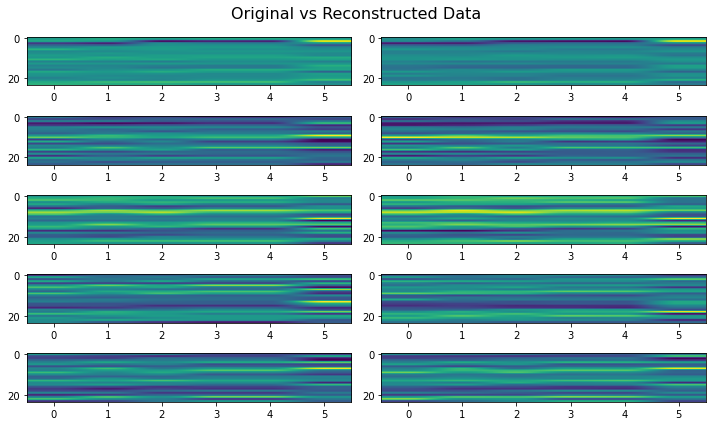

23/23 [==============================] - 0s 2ms/step


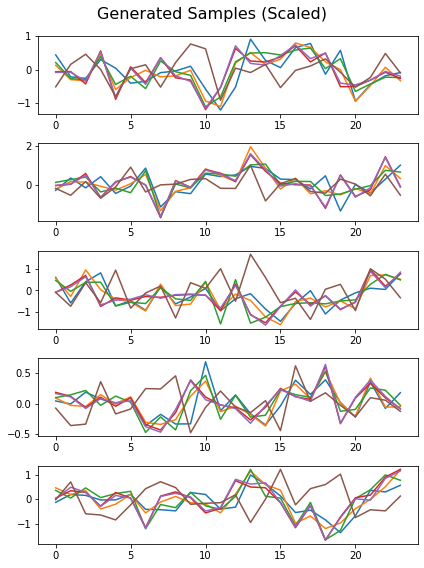

In [13]:

# ----------------------------------------------------------------------------------
# instantiate the model     

latent_dim = 8

if vae_type == 'vae_dense': 
    vae = VAE_Dense( seq_len=T,  feat_dim = D, latent_dim = latent_dim, hidden_layer_sizes=[200,100], )
elif vae_type == 'vae_conv':
    vae = VAE_Conv( seq_len=T,  feat_dim = D, latent_dim = latent_dim, hidden_layer_sizes=[100, 200] )
elif vae_type == 'timeVAE':
    vae = TimeVAE( seq_len=T,  feat_dim = D, latent_dim = latent_dim, hidden_layer_sizes=[50, 100, 200],        #[80, 200, 250] 
            reconstruction_wt = 3.0,
            # ---------------------
            # disable following three arguments to use the model as TimeVAE_Base. Enabling will convert to Interpretable version.
            # Also set use_residual_conn= False if you want to only have interpretable components, and no residual (non-interpretable) component. 
            
            # trend_poly=2, 
            # custom_seas = [ (6,1), (7, 1), (8,1), (9,1)] ,     # list of tuples of (num_of_seasons, len_per_season)
            # use_scaler = True,
            
            #---------------------------
            use_residual_conn = True
        )   
else:  raise Exception('wut')


vae.compile(optimizer=Adam())
# vae.summary() ; sys.exit()

early_stop_loss = 'loss'
early_stop_callback = EarlyStopping(monitor=early_stop_loss, min_delta = 1e-1, patience=10) 
reduceLR = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=5)

vae.fit(
    scaled_train_data, 
    batch_size = 32,
    epochs=500,
    shuffle = True,
    callbacks=[early_stop_callback, reduceLR],
    verbose = 1
)

# ----------------------------------------------------------------------------------    
# save model 
model_dir = './model/'
file_pref = f'vae_{vae_type}_{dataset}_perc_{perc_of_train_used}_iter_{0}_'
vae.save(model_dir, file_pref)

# ----------------------------------------------------------------------------------
# visually check reconstruction 
X = scaled_train_data

x_decoded = vae.predict(scaled_train_data)
print('x_decoded.shape', x_decoded.shape)

### compare original and posterior predictive (reconstructed) samples
utils.draw_orig_and_post_pred_sample(X, x_decoded, n=5)


# # Plot the prior generated samples over different areas of the latent space
if latent_dim == 2: utils.plot_latent_space_timeseries(vae, n=8, figsize = (20, 10))
    
# # ----------------------------------------------------------------------------------
# draw random prior samples
num_samples = N_train
# print("num_samples: ", num_samples)

samples = vae.get_prior_samples(num_samples=num_samples)

utils.plot_samples(samples, n=5)

In [14]:


# inverse-transform scaling 
# samples = scaler.inverse_transform(samples)
samples = inverse_trans(samples, scaler)
print('shape of gen samples: ', samples.shape) 

# ----------------------------------------------------------------------------------
# save samples
output_dir = './outputs/'
sample_fname = f'{vae_type}_gen_samples_{dataset}_perc_{perc_of_train_used}.npz' 
samples_fpath = os.path.join(output_dir, sample_fname) 
np.savez_compressed(samples_fpath, data=samples)

# ----------------------------------------------------------------------------------

# later.... load model 
if vae_type == 'timeVAE':
    new_vae = TimeVAE.load(model_dir, file_pref)
elif vae_type == 'vae_conv':
    new_vae = VAE_Conv.load(model_dir, file_pref)
else:
    new_vae = VAE_Dense.load(model_dir, file_pref)

new_x_decoded = new_vae.predict(scaled_train_data)
# print('new_x_decoded.shape', new_x_decoded.shape)

print('Preds from orig and loaded models equal: ', np.allclose( x_decoded,  new_x_decoded, atol=1e-5))        

# ----------------------------------------------------------------------------------

end = time.time()
print(f"Total run time: {np.round((end - start)/60.0, 2)} minutes") 

shape of gen samples:  (732, 24, 6)
23/23 [==============================] - 0s 2ms/step
Preds from orig and loaded models equal:  True
Total run time: 1.06 minutes


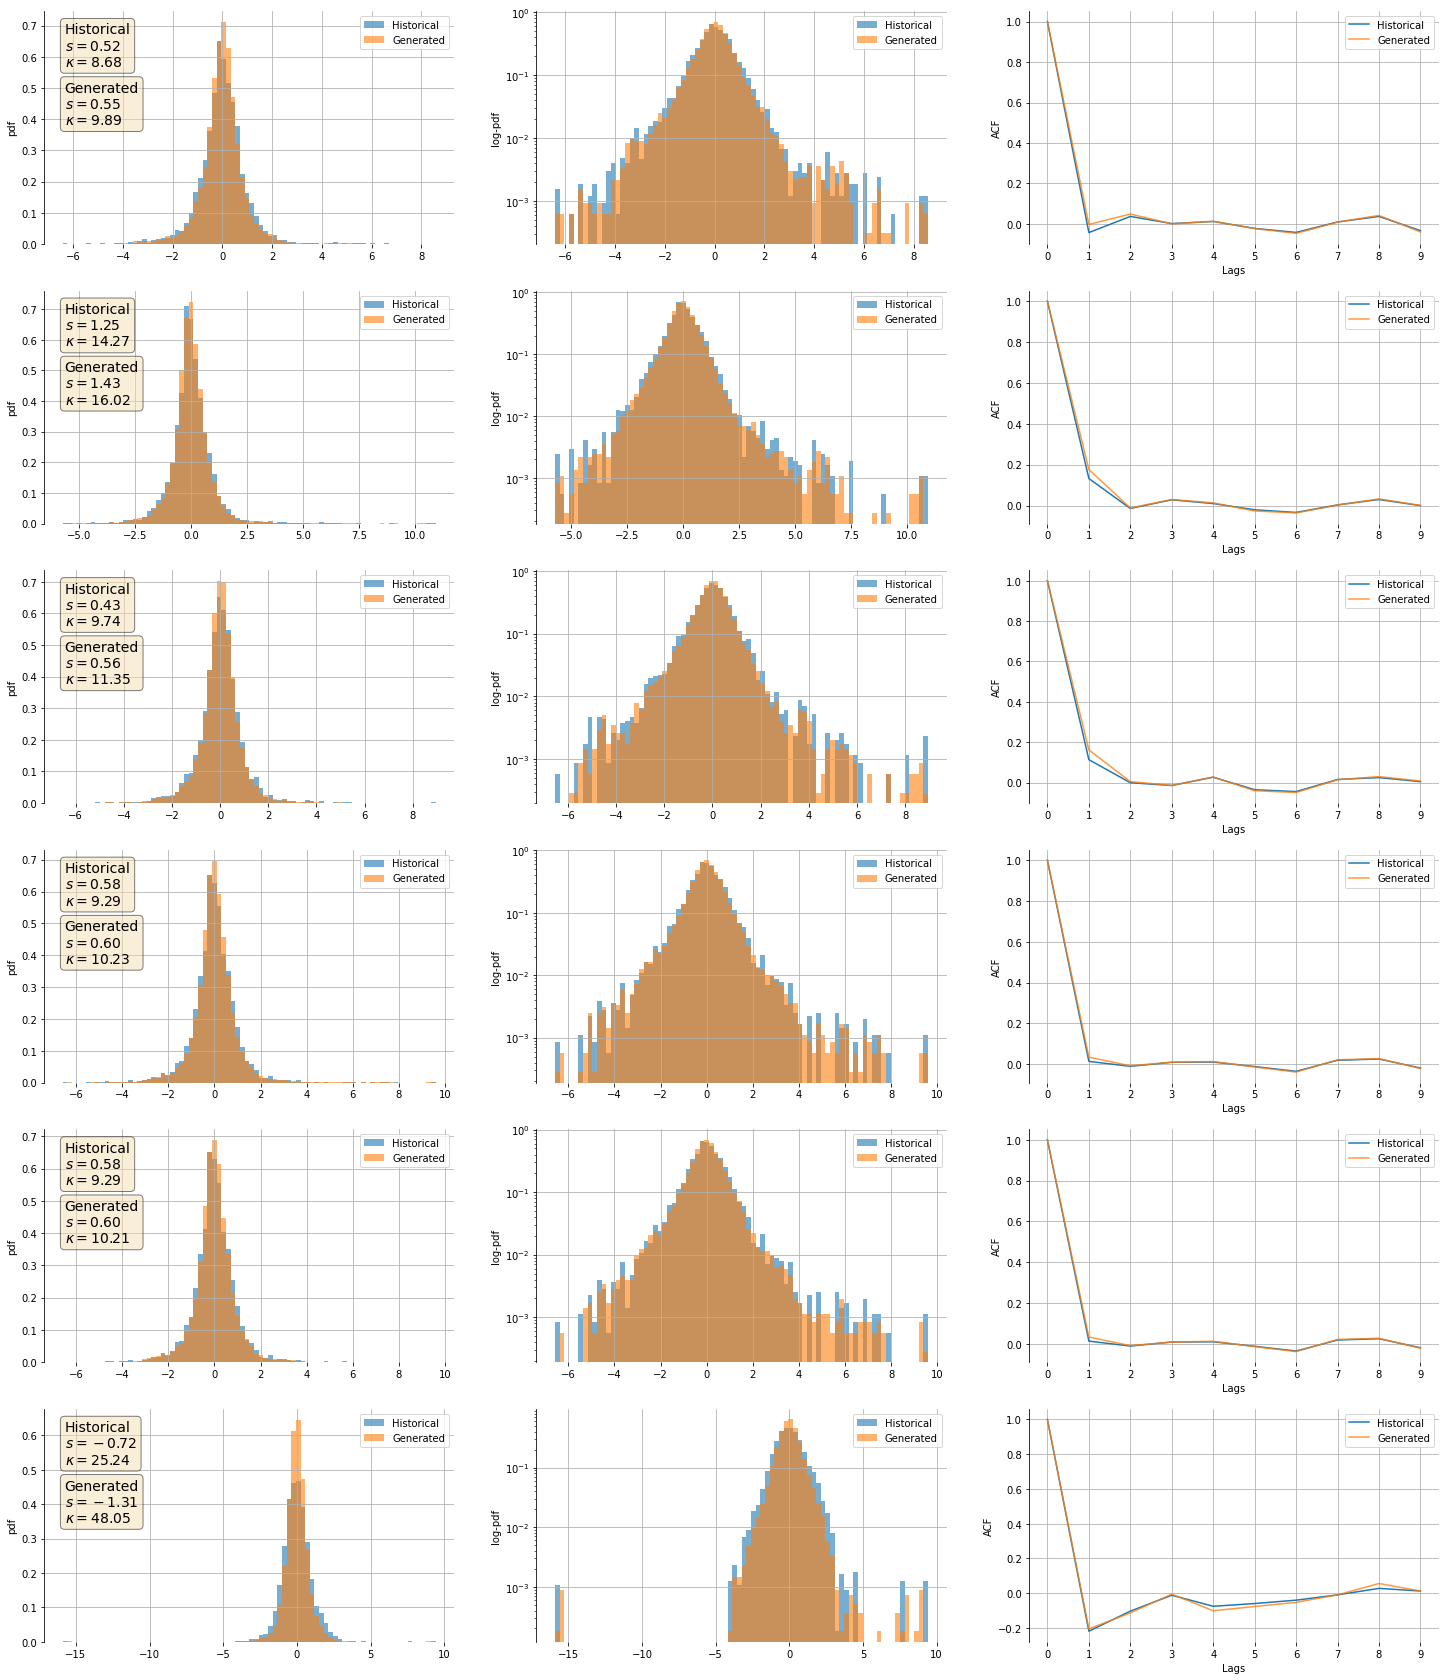

In [15]:
from lib.plot import *
plot_summary(x_fake=torch.from_numpy(new_x_decoded), x_real=torch.from_numpy(scaled_train_data), max_lag=10)

In [16]:
# import random
# import numpy
# from matplotlib import pyplot

# bins = numpy.linspace(-5, 5, 100)
# for i in range(D):

#     pyplot.hist(scaled_train_data[:,:,i], bins, alpha=0.5, label='Real')
#     pyplot.hist(new_x_decoded[:,:,i], bins, alpha=0.5, label='Synthetic')
#     pyplot.legend(loc='upper right')
#     pyplot.show()

In [17]:
sys.path.insert(0, '../metrics/')
# from discriminative_metrics3 import discriminative_score_metrics
from discriminative_metrics2 import discriminative_score_metrics
from predictive_metrics3 import predictive_score_metrics
from visualization_metrics import visualization

In [18]:
metric_iteration = 2

pred_epochs = 50
disc_epochs = 50 

print_period = 10

predictive_score, discriminative_score = [], []
for tt in range(metric_iteration):
    temp_pred = predictive_score_metrics(scaled_train_data, new_x_decoded, 
                                            predictor = 'conv', # conv, rnn, nbeats
                                            epochs = pred_epochs, print_epochs = print_period)
#         temp_pred = -1
    predictive_score.append(temp_pred)  
#         print(temp_pred); continue

    temp_disc = discriminative_score_metrics(scaled_train_data, new_x_decoded, print_epochs=print_period)
#         temp_disc = -1
    discriminative_score.append(temp_disc)   
    print(tt, temp_pred, temp_disc)  


Pred Avg. train / val loss for epoch 10: 0.559 / 0.616 
Pred Avg. train / val loss for epoch 20: 0.557 / 0.616 
Pred Avg. train / val loss for epoch 30: 0.557 / 0.615 
Pred Avg. train / val loss for epoch 40: 0.555 / 0.613 
Pred Avg. train / val loss for epoch 50: 0.548 / 0.6 
Disc Avg. train / val loss for epoch 10: 0.693 / 0.679 
Disc Avg. train / val loss for epoch 20: 0.686 / 0.678 
Disc Avg. train / val loss for epoch 30: 0.678 / 0.674 
Disc Avg. train / val loss for epoch 40: 0.667 / 0.663 
Disc Avg. train / val loss for epoch 50: 0.642 / 0.624 
Disc Avg. train / val loss for epoch 60: 0.553 / 0.495 
Disc Avg. train / val loss for epoch 70: 0.507 / 0.455 
Disc Avg. train / val loss for epoch 80: 0.472 / 0.424 
Disc Avg. train / val loss for epoch 90: 0.442 / 0.4 
Disc Avg. train / val loss for epoch 100: 0.41 / 0.379 
Disc Avg. train / val loss for epoch 110: 0.397 / 0.383 
Disc Avg. train / val loss for epoch 120: 0.383 / 0.367 
Disc Avg. train / val loss for epoch 130: 0.376 / 

------------------------------------------------------------------------------------------
Visualizations:


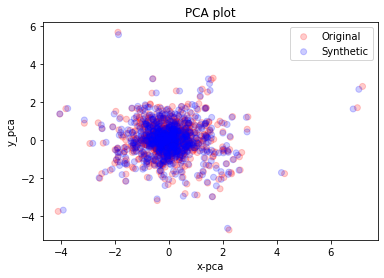

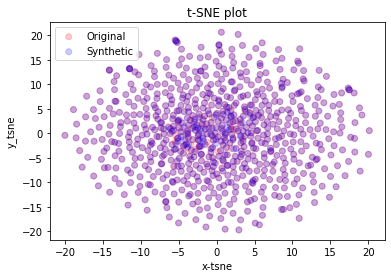

In [19]:
print("-"*90); print('Visualizations:')
visualization(scaled_train_data[0:new_x_decoded.shape[0]], new_x_decoded, 'pca')
visualization(scaled_train_data[0:new_x_decoded.shape[0]], new_x_decoded, 'tsne')